In [25]:
#! pip install -r requirements.txt

In [26]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
#from utils import *

In [27]:
# Move data into training and validation directories
import os
from tqdm import tqdm
import glob

INPUT_PATH = 'data/pokemonclassification/PokemonData/'

os.makedirs('data/pokemonclassification/images/train/class/', exist_ok=True) # 6,000 images
os.makedirs('data/pokemonclassification/images/val/class/', exist_ok=True)   #  200 images

for i, file in tqdm(enumerate(glob.glob("data/pokemonclassification/PokemonData/*/*.jpg"))):
  if i < 200: # first 200 will be val
    shutil.copy(file, 'data/pokemonclassification/images/val/class/')
  else: # others will be val
    shutil.copy(file, 'data/pokemonclassification/images/train/class/')

6659it [00:02, 2462.88it/s]


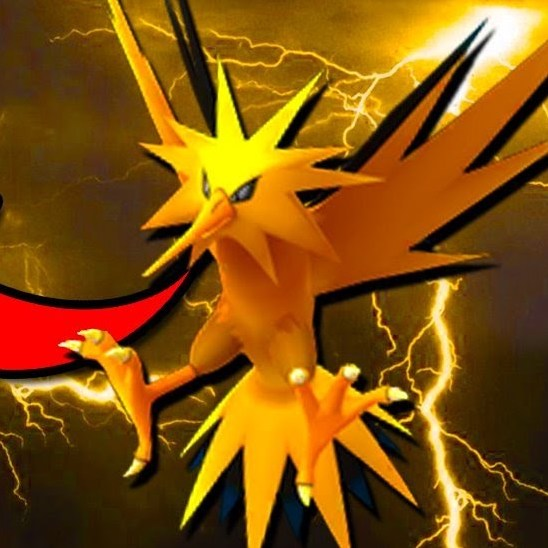

In [28]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='data/pokemonclassification/images/train/class/2b7870f2174e4a1d9e13bc0bb71fd35b.jpg'))

In [29]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [30]:
model = ColorizationNet()
# Check if GPU is available
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [31]:
criterion = nn.MSELoss()

In [32]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [33]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('data/pokemonclassification/images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('data/pokemonclassification/images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [34]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: 
      input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'data/pokemonclassification/outputs/gray/', 'colorized': 'data/pokemonclassification/outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [35]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: 
      input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [36]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))


In [37]:
# Make folders and set parameters
os.makedirs('data/pokemonclassification/outputs/color', exist_ok=True)
os.makedirs('data/pokemonclassification/outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()
  print("Model is now on GPU.")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

Model is now on GPU.


In [38]:
# Train model
loss_history = []
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
    loss_history.append(losses)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))


Starting training epoch 0
Epoch: [0][0/101]	Time 1.888 (1.888)	Data 1.513 (1.513)	Loss 0.3925 (0.3925)	
Epoch: [0][25/101]	Time 1.451 (1.467)	Data 1.401 (1.404)	Loss 0.0236 (0.1898)	
Epoch: [0][50/101]	Time 1.610 (1.537)	Data 1.561 (1.480)	Loss 0.0097 (0.1033)	
Epoch: [0][75/101]	Time 1.590 (1.562)	Data 1.541 (1.507)	Loss 0.0089 (0.0723)	
Epoch: [0][100/101]	Time 0.567 (1.567)	Data 0.543 (1.513)	Loss 0.0109 (0.0569)	
Finished training epoch 0


C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 48 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 126 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 68 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.965 (1.965)	Loss 0.0081 (0.0081)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/101]	Time 1.741 (1.741)	Data 1.441 (1.441)	Loss 0.0096 (0.0096)	
Epoch: [1][25/101]	Time 1.409 (1.452)	Data 1.357 (1.390)	Loss 0.0086 (0.0085)	
Epoch: [1][50/101]	Time 1.455 (1.447)	Data 1.405 (1.390)	Loss 0.0076 (0.0083)	
Epoch: [1][75/101]	Time 1.438 (1.450)	Data 1.389 (1.394)	Loss 0.0080 (0.0082)	
Epoch: [1][100/101]	Time 0.517 (1.442)	Data 0.492 (1.388)	Loss 0.0080 (0.0081)	
Finished training epoch 1


C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 102 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 34 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.698 (1.698)	Loss 0.0073 (0.0073)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/101]	Time 1.527 (1.527)	Data 1.370 (1.370)	Loss 0.0076 (0.0076)	
Epoch: [2][25/101]	Time 1.594 (1.456)	Data 1.544 (1.401)	Loss 0.0083 (0.0078)	
Epoch: [2][50/101]	Time 1.516 (1.461)	Data 1.447 (1.407)	Loss 0.0085 (0.0078)	
Epoch: [2][75/101]	Time 1.420 (1.460)	Data 1.371 (1.407)	Loss 0.0084 (0.0080)	
Epoch: [2][100/101]	Time 0.503 (1.451)	Data 0.478 (1.399)	Loss 0.0077 (0.0079)	
Finished training epoch 2


C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.733 (1.733)	Loss 0.0075 (0.0075)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/101]	Time 1.716 (1.716)	Data 1.422 (1.422)	Loss 0.0077 (0.0077)	
Epoch: [3][25/101]	Time 1.497 (1.483)	Data 1.447 (1.423)	Loss 0.0065 (0.0077)	
Epoch: [3][50/101]	Time 1.497 (1.504)	Data 1.448 (1.449)	Loss 0.0082 (0.0076)	
Epoch: [3][75/101]	Time 1.461 (1.493)	Data 1.413 (1.439)	Loss 0.0084 (0.0077)	
Epoch: [3][100/101]	Time 0.509 (1.480)	Data 0.484 (1.427)	Loss 0.0082 (0.0077)	
Finished training epoch 3
Validate: [0/4]	Time 1.711 (1.711)	Loss 0.0071 (0.0071)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/101]	Time 1.760 (1.760)	Data 1.519 (1.519)	Loss 0.0076 (0.0076)	
Epoch: [4][25/101]	Time 1.498 (1.476)	Data 1.449 (1.418)	Loss 0.0068 (0.0077)	
Epoch: [4][50/101]	Time 1.463 (1.481)	Data 1.414 (1.426)	Loss 0.0079 (0.0076)	
Epoch: [4][75/101]	Time 1.490 (1.477)	Data 1.441 (1.423)	Loss 0.0080 (0.0076)	
Epoch: [4][100/101]	Time 0.521 (1.462)	Data 0.497 (1.409

C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 2291 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 428 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 3521 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.728 (1.728)	Loss 0.0070 (0.0070)	
Finished validation.
Starting training epoch 5
Epoch: [5][0/101]	Time 1.740 (1.740)	Data 1.458 (1.458)	Loss 0.0078 (0.0078)	
Epoch: [5][25/101]	Time 1.379 (1.461)	Data 1.330 (1.401)	Loss 0.0076 (0.0077)	
Epoch: [5][50/101]	Time 1.352 (1.459)	Data 1.301 (1.404)	Loss 0.0065 (0.0075)	
Epoch: [5][75/101]	Time 1.486 (1.452)	Data 1.421 (1.398)	Loss 0.0071 (0.0076)	
Epoch: [5][100/101]	Time 0.509 (1.446)	Data 0.483 (1.393)	Loss 0.0074 (0.0075)	
Finished training epoch 5


C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 5006 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 3244 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 771 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 10025 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.728 (1.728)	Loss 0.0069 (0.0069)	
Finished validation.
Starting training epoch 6
Epoch: [6][0/101]	Time 1.704 (1.704)	Data 1.403 (1.403)	Loss 0.0062 (0.0062)	
Epoch: [6][25/101]	Time 1.479 (1.480)	Data 1.428 (1.418)	Loss 0.0079 (0.0074)	
Epoch: [6][50/101]	Time 1.436 (1.478)	Data 1.387 (1.422)	Loss 0.0075 (0.0076)	
Epoch: [6][75/101]	Time 1.427 (1.471)	Data 1.378 (1.416)	Loss 0.0075 (0.0076)	
Epoch: [6][100/101]	Time 0.519 (1.457)	Data 0.496 (1.404)	Loss 0.0079 (0.0078)	
Finished training epoch 6


C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 2531 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 420 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 3645 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.908 (1.908)	Loss 0.0068 (0.0068)	
Finished validation.
Starting training epoch 7
Epoch: [7][0/101]	Time 1.668 (1.668)	Data 1.466 (1.466)	Loss 0.0078 (0.0078)	
Epoch: [7][25/101]	Time 1.417 (1.466)	Data 1.367 (1.408)	Loss 0.0070 (0.0080)	
Epoch: [7][50/101]	Time 1.470 (1.459)	Data 1.420 (1.405)	Loss 0.0065 (0.0078)	
Epoch: [7][75/101]	Time 1.476 (1.455)	Data 1.425 (1.402)	Loss 0.0062 (0.0076)	
Epoch: [7][100/101]	Time 0.524 (1.446)	Data 0.500 (1.393)	Loss 0.0090 (0.0076)	
Finished training epoch 7
Validate: [0/4]	Time 1.690 (1.690)	Loss 0.0071 (0.0071)	
Finished validation.
Starting training epoch 8
Epoch: [8][0/101]	Time 1.634 (1.634)	Data 1.416 (1.416)	Loss 0.0073 (0.0073)	
Epoch: [8][25/101]	Time 1.448 (1.474)	Data 1.399 (1.417)	Loss 0.0065 (0.0074)	
Epoch: [8][50/101]	Time 1.475 (1.475)	Data 1.409 (1.420)	Loss 0.0073 (0.0074)	
Epoch: [8][75/101]	Time 1.431 (1.465)	Data 1.380 (1.411)	Loss 0.0062 (0.0074)	
Epoch: [8][100/101]	Time 0.531 (1.451)	Data 0.507 (1.398

C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 1641 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 72 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 2044 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.661 (1.661)	Loss 0.0070 (0.0070)	
Finished validation.
Starting training epoch 17
Epoch: [17][0/101]	Time 1.644 (1.644)	Data 1.430 (1.430)	Loss 0.0079 (0.0079)	
Epoch: [17][25/101]	Time 1.523 (1.453)	Data 1.474 (1.396)	Loss 0.0070 (0.0072)	
Epoch: [17][50/101]	Time 1.473 (1.441)	Data 1.422 (1.387)	Loss 0.0077 (0.0072)	
Epoch: [17][75/101]	Time 1.395 (1.462)	Data 1.346 (1.408)	Loss 0.0080 (0.0072)	
Epoch: [17][100/101]	Time 0.557 (1.452)	Data 0.530 (1.399)	Loss 0.0078 (0.0073)	
Finished training epoch 17
Validate: [0/4]	Time 1.708 (1.708)	Loss 0.0067 (0.0067)	
Finished validation.
Starting training epoch 18
Epoch: [18][0/101]	Time 1.592 (1.592)	Data 1.326 (1.326)	Loss 0.0071 (0.0071)	
Epoch: [18][25/101]	Time 1.579 (1.459)	Data 1.531 (1.401)	Loss 0.0069 (0.0071)	
Epoch: [18][50/101]	Time 1.517 (1.460)	Data 1.464 (1.406)	Loss 0.0083 (0.0070)	
Epoch: [18][75/101]	Time 1.329 (1.723)	Data 1.280 (1.526)	Loss 0.0079 (0.0072)	
Epoch: [18][100/101]	Time 0.469 (1.623)	Data

C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 1558 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 1932 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.630 (1.630)	Loss 0.0068 (0.0068)	
Finished validation.
Starting training epoch 25
Epoch: [25][0/101]	Time 1.529 (1.529)	Data 1.395 (1.395)	Loss 0.0073 (0.0073)	
Epoch: [25][25/101]	Time 1.471 (1.434)	Data 1.421 (1.378)	Loss 0.0072 (0.0074)	
Epoch: [25][50/101]	Time 1.432 (1.429)	Data 1.383 (1.376)	Loss 0.0057 (0.0072)	
Epoch: [25][75/101]	Time 1.453 (1.428)	Data 1.405 (1.376)	Loss 0.0092 (0.0072)	
Epoch: [25][100/101]	Time 0.495 (1.420)	Data 0.467 (1.368)	Loss 0.0059 (0.0073)	
Finished training epoch 25
Validate: [0/4]	Time 1.660 (1.660)	Loss 0.0064 (0.0064)	
Finished validation.
Starting training epoch 26
Epoch: [26][0/101]	Time 1.643 (1.643)	Data 1.370 (1.370)	Loss 0.0071 (0.0071)	
Epoch: [26][25/101]	Time 1.400 (1.450)	Data 1.351 (1.391)	Loss 0.0073 (0.0071)	
Epoch: [26][50/101]	Time 1.384 (1.436)	Data 1.335 (1.381)	Loss 0.0075 (0.0072)	
Epoch: [26][75/101]	Time 1.404 (1.435)	Data 1.354 (1.381)	Loss 0.0077 (0.0072)	
Epoch: [26][100/101]	Time 0.482 (1.422)	Data

C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 7798 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 5741 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 5374 pixels
  return func(*args, **kwargs)
C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 14593 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.674 (1.674)	Loss 0.0076 (0.0076)	
Finished validation.
Starting training epoch 34
Epoch: [34][0/101]	Time 1.523 (1.523)	Data 1.366 (1.366)	Loss 0.0076 (0.0076)	
Epoch: [34][25/101]	Time 1.421 (1.422)	Data 1.371 (1.368)	Loss 0.0075 (0.0073)	
Epoch: [34][50/101]	Time 1.420 (1.425)	Data 1.372 (1.373)	Loss 0.0064 (0.0071)	
Epoch: [34][75/101]	Time 1.398 (1.422)	Data 1.349 (1.370)	Loss 0.0078 (0.0071)	
Epoch: [34][100/101]	Time 0.485 (1.415)	Data 0.461 (1.364)	Loss 0.0081 (0.0071)	
Finished training epoch 34
Validate: [0/4]	Time 1.657 (1.657)	Loss 0.0064 (0.0064)	
Finished validation.
Starting training epoch 35
Epoch: [35][0/101]	Time 1.677 (1.677)	Data 1.403 (1.403)	Loss 0.0073 (0.0073)	
Epoch: [35][25/101]	Time 1.453 (1.429)	Data 1.403 (1.371)	Loss 0.0064 (0.0072)	
Epoch: [35][50/101]	Time 1.427 (1.428)	Data 1.379 (1.373)	Loss 0.0073 (0.0071)	
Epoch: [35][75/101]	Time 1.436 (1.432)	Data 1.387 (1.379)	Loss 0.0093 (0.0071)	
Epoch: [35][100/101]	Time 0.647 (1.423)	Data

C:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 16 pixels
  return func(*args, **kwargs)


Validate: [0/4]	Time 1.697 (1.697)	Loss 0.0066 (0.0066)	
Finished validation.
Starting training epoch 38
Epoch: [38][0/101]	Time 1.561 (1.561)	Data 1.451 (1.451)	Loss 0.0063 (0.0063)	
Epoch: [38][25/101]	Time 1.452 (1.445)	Data 1.403 (1.391)	Loss 0.0078 (0.0072)	
Epoch: [38][50/101]	Time 1.477 (1.435)	Data 1.427 (1.383)	Loss 0.0070 (0.0072)	
Epoch: [38][75/101]	Time 1.352 (1.431)	Data 1.303 (1.379)	Loss 0.0071 (0.0071)	
Epoch: [38][100/101]	Time 0.486 (1.424)	Data 0.462 (1.372)	Loss 0.0065 (0.0071)	
Finished training epoch 38
Validate: [0/4]	Time 1.690 (1.690)	Loss 0.0066 (0.0066)	
Finished validation.
Starting training epoch 39
Epoch: [39][0/101]	Time 1.577 (1.577)	Data 1.401 (1.401)	Loss 0.0069 (0.0069)	
Epoch: [39][25/101]	Time 1.417 (1.435)	Data 1.360 (1.378)	Loss 0.0061 (0.0073)	
Epoch: [39][50/101]	Time 1.400 (1.430)	Data 1.350 (1.375)	Loss 0.0074 (0.0071)	
Epoch: [39][75/101]	Time 1.372 (1.427)	Data 1.324 (1.374)	Loss 0.0070 (0.0070)	
Epoch: [39][100/101]	Time 0.499 (1.417)	Data

<Figure size 432x288 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


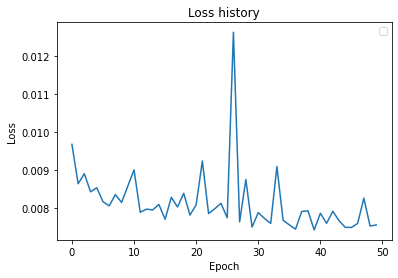

In [41]:
plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss history")
plt.legend()
plt.show()

In [40]:
# Show images 
import matplotlib.image as mpimg

image_pairs = [('data/pokemonclassification/outputs/color/img-3-epoch-199.jpg', 'data/pokemonclassification/outputs/gray/img-3-epoch-0.jpg'),
               ('data/pokemonclassification/outputs/color/img-9-epoch-199.jpg', 'data/pokemonclassification/outputs/gray/img-9-epoch-0.jpg')]
               
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/pokemonclassification/outputs/color/img-3-epoch-199.jpg'